# Защита персональных данных клиентов

## Задачи проекта
* Защитить данные клиентов страховой компании «Хоть потоп»:
    1. Разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.
    2. Обосновать корректность работы метода.

## Дополнительные критерии
* При преобразовании качество моделей машинного обучения не должно ухудшиться.
* Подбирать наилучшую модель не требуется.

## Загрузка данных

### Подготовка библиотек

In [1]:
# Файлы и директории
import os 

# Датафреймы
import pandas as pd

# Математика
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Машинное обучение
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Константы
RANDOM_NUMBER = 12345

### Загрузка датасета

In [2]:
pth1 = 'datasets/insurance.csv'
pth2 = '/insurance.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)

else:
    print("Something went wrong")

### Знакомство с данными

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


In [5]:
df.tail(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4990,0,22.0,56800.0,1,0
4991,0,21.0,38300.0,3,0
4992,0,45.0,54600.0,0,1
4993,1,32.0,36000.0,1,0
4994,1,26.0,51400.0,0,0
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


**Наблюдения**

В данных сохранено 5000 объектов с 5-ю признаками:
1. `Пол` — закодирован через 0 и 1
2. `Возраст`
3. `Зарплата`
4. `Члены семьи`
5. `Страховые выплаты` — целевой признак, количество выплат клиенту за последние 5 лет.

### Предобработка

Проверим датафрейм на наличие пропусков и дубликатов:

In [6]:
df.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

Пропуски отсутствуют.

In [7]:
df.duplicated().sum()

153

Обнаружено 153 дубликата. Отбросим их:

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Преобразозвание типов

В столбцах `Возраст` и `Зарплата` находятся целочисленные значения. Приведём их к типу `int`: 

In [9]:
df[['Возраст', 'Зарплата']] = df[['Возраст', 'Зарплата']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                4847 non-null   int64
 1   Возраст            4847 non-null   int64
 2   Зарплата           4847 non-null   int64
 3   Члены семьи        4847 non-null   int64
 4   Страховые выплаты  4847 non-null   int64
dtypes: int64(5)
memory usage: 227.2 KB


Данне предобработаны: пропуски и дубликаты отсутствуют, целочисленные признаки приведены к типу `int`.

### Поиск корреляций

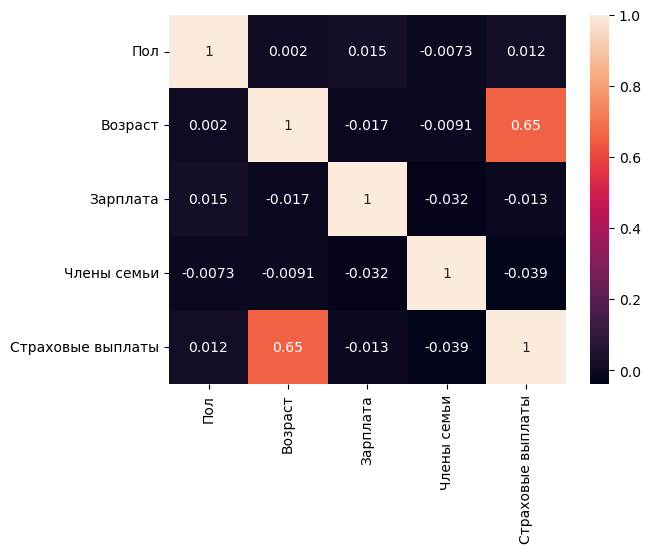

In [10]:
sns.heatmap(df.corr(), annot=True);

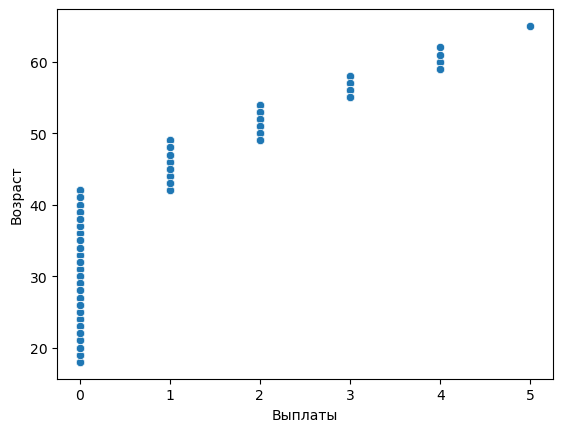

In [11]:
sns.scatterplot(data=df, x='Страховые выплаты', y='Возраст')
plt.xlabel('Выплаты')
plt.ylabel('Возраст');

Наблюдается заметная положительная корреляция между возрастом застрахованных и количеством страховых выплат. Зафиксируем пару предположений о взаимосвязи этих двух признаков:
* Люди старшего возраста дольше являются клиентами компании, поэтому статистически успели получить больше выплат.
* Люди старшего возраста менее внимательны или имеют больше проблем со здоровьем, поэтому чаще попадают в ситуации, подразумевающие страховые выплаты.

На основе предоставленных данных мы не можем ни подтвердить, ни опровергнуть эти гипотезы. Поэтому оставим их в качестве предположений.

### Подготовка выборок для обучения

Разделим данные на тренировочную и тестовую выборки в сотношении 3:1.

In [12]:
X = df.drop(['Страховые выплаты'], axis=1)
y = df['Страховые выплаты']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_NUMBER)

# Проверка
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3635, 4), (3635,), (1212, 4), (1212,))

Разделение произведено корректно.

### Подготовка вспомогательных функций

Создадим функцию для отображения метрик $MSE$ и $R^2$:

In [13]:
def show_metrics(y_test, y_pred):
    
    print(f"MSE: {mean_squared_error(y_test, y_pred).round(3)}")
    print(f"R2: {r2_score(y_test, y_pred).round(3)}")

### Итоги этапа
* Данные успешно загружены.
* Пропуски и дубликаты обработаны.
* Обнаружена корреляция между возрастом застрахованных и количеством страховых выплат.
* Датасет разеделён на тренировочную и тестовую выборки.
* Реализована вспомогательная функция для отображения метрик.


## Умножение матриц

**Вопрос.** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? 

**Ответ.** Не изменится.

**Обоснование.** При домножении признаков на обратимую матрицу, вектор предсказанных значений и метрики $MSE$ и $R^2$ остаются неизменными, что говорит о сохраненни качества линейной регрессии.

Обоснуем этот вывод аналитически и эмпирически.


### Аналитическое доказательство

**Обозначения**

*Исходный набор данных*

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака
- $\hat{y}$ — предсказания по исходной матрице признаков

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

*Изменённый набор данных*

- $P$ — матрица, на которую умножаются признаки
- $w*$ — вектор весов после умножения исходной матрицы на любую обратимую
- $\hat{y}*$ — предсказания по матрице полученной домноженной на обратимую матрицу
- $E$ — единичная матрица

**(1) Предсказания:**

$$
a = Xw
$$

**(2) Задача обучения:**

$$
w = \arg\min_w MSE(Xw, y)
$$

**(3) Формула обучения:**

$$
w = (X^T X)^{-1} X^T y
$$

**Используемые свойства:**

**(I)**$$
(AB)^T=B^T A^T
$$

**(II)**$$
(AB)^{-1} = B^{-1} A^{-1}
$$

**(III)**$$
A A^{-1} = A^{-1} A = E
$$

**(IV)**$$
AE = EA = A
$$

$A, B$ — обратимые матрицы, $E$ — единичная матрица

**Доказательство**
$$
a = Xw = XEw = XPP^{-1}w = (XP)P^{-1}w = (XP)w' ????
$$
\
Требуется доказать, что предсказания не изменятся:

$$
a=a'
$$

Формулы для предсказаний на исходных и изменённых данных:
$$a =  Xw$$  $$a' = X'w'$$


Веса для исходных данных:
$$
    w = (X^T X)^{-1} X^T y
$$

Веса для изменённых данных:
$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$

$$
w' = (P^T (X^T X) P)^{-1} P^T X^T y
$$

Применим свойство **(II)** для $(P^T (X^T X) P)^{-1}$:

$$
w' = P^{-1}(X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

По свойству **(III)** $(P^T)^{-1} P^T = E$, следовательно:

$$
w' = P^{-1}(X^T X)^{-1} X^T y
$$

Подставим $X'$ и $w'$ в формулу для $a'$:

$$
a' = X'w'= XPP^{-1}(X^T X)^{-1}X^Ty
$$

Так как по свойству **(III)** $PP^{-1}=E$, получим:

$$
a'= X(X^TX)^{-1}X^Ty
$$

Формула **(1)** для предсказаний $a$ на неизменённом наборе данных:

$$
a = Xw =X(X^T X)^{-1} X^T y
$$

Из двух последних формул следует, что: $$a=a'$$

Таким образом, при домножении исходного набора данных на любую необратимую матрицу, предсказания остаются неизменными. Следовательно, качество линейной регрессии сохраняется. █

### Эмпирическое доказательство

Создадим локальную модель линейной регрессии для предсказания значений по неизменённым признакам:

In [14]:
class LocalLinearRegression:
    
    def fit(self, X_train, y_train):
        
        # Добавление единичного столбца в вектор X
        X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
        
        # Целевой признак
        y = y_train
        
        # Вектор весов —> формула обучения (3)
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        
        # Сдвиг w0 
        self.w0 = w[0]
        
        # Веса w1...wn
        self.w = w[1:]

    
    def predict(self, X_test):
        
        # Вектор предсказаний
        return X_test.dot(self.w) + self.w0

Обучим модель и вычислим метрики $MSE$ и $R^2$:

In [15]:
# Инициализаия и тренировка модели
LR_model = LocalLinearRegression()
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)

# Проверка
show_metrics(y_test, y_pred)

MSE: 0.12
R2: 0.423


Создадим произвольную матрицу по длине совпадающую с шириной выборки и проверим её на обратимость:

In [16]:
P = np.random.normal(5, size=(4,4))

# Проверка
display(P)
display(np.linalg.inv(P))

array([[5.74187738, 3.8181052 , 5.73022791, 4.79571629],
       [5.68220341, 4.33560385, 4.06408463, 5.13068735],
       [6.12436609, 6.93204518, 6.28722523, 5.19496953],
       [5.68287386, 5.90239571, 6.31800152, 5.28953113]])

array([[ 0.72932108,  0.0419869 ,  1.03648315, -1.71991369],
       [-0.37136469,  0.01548498,  0.39828337, -0.06948799],
       [ 0.31004992, -0.4914183 , -0.18275719,  0.37504652],
       [-0.73949734,  0.52457897, -1.33969697,  1.66643384]])

Умножим тренировочные и тестовые признаки на произвольную матрицу:

In [17]:
X_train_dot = X_train.dot(P)
X_train_dot.columns = X_train.columns

X_test_dot = X_test.dot(P)
X_test_dot.columns = X_test.columns

# Проверка
display(X_train_dot.head())
display(X_test_dot.head())

,Пол,Возраст,Зарплата,Члены семьи
4599,333948.419484,377929.664158,342780.205363,283280.077522
3882,310732.709370,351629.164212,318928.802565,263590.006378
4705,171624.306346,194207.222005,176146.162450,145587.572780
1400,237892.467949,269167.126471,244135.350870,201805.959947
728,199274.869016,225470.794989,204503.701335,169047.026648


,Пол,Возраст,Зарплата,Члены семьи
1335,289206.512122,327296.069619,296856.234992,245325.363193
3875,403783.297882,456964.334971,414463.923539,342517.469531
166,207820.630873,235155.029518,213289.416293,176294.154422
3003,118433.237266,133969.365368,121514.582227,100473.587737
424,168692.814648,190842.485094,173098.277698,143108.252669


Обучим модель на изменённых признаках и проверим метрики:

In [18]:
LR_matrix_model = LocalLinearRegression()
LR_matrix_model.fit(X_train_dot, y_train)
y_pred = LR_matrix_model.predict(X_test_dot)

# Проверка
show_metrics(y_test, y_pred)

MSE: 0.12
R2: 0.423


Значения метрик $MSE$ и $R^2$ остались прежними. Аналитический вывод подтвердился эмпирически. █

### Итоги этапа
* При домножении матрицы исходных данных на обратимую матрицу качество линейно регрессии осталось неизменным.
* Вывод о сохранении качества подтверждён аналитически и эмпирически.

## Алгоритм преобразования

**Алгоритм**
1. Создать случайную квадратную матрицу $P$ с размернойстью равной количеству обучающих признаков
2. Проверить матрицу $P$ на обратимость. Если $P$ — необратима, вернуться к шагу 1.
    
3. Домножить матрицы обучающих и тестовых признаков на матрицу $P$.

**Обоснование**

На предыдущем этапе мы выяснили, что при домножении матрицы целевых признаков на обратимую матрицу, качество линейной регрессии остаётся неизменным. При этом, сам набор значений кардинально меняется. Это свойство и будет работать в качестве алгоритма защиты данных.

## Проверка алгоритма

### Подготовка

Создадим функцию, которая на входе будет получать тренировочную и тестовую выборки, а на выходе возвращать их в зашифрованном виде.

In [19]:
def data_cypher(X_train, X_test):
    
    # Размерность признаков
    n = X_train.shape[1]
    
    # Функция генерации обратимой матрицы
    def inv_matrix():
        while True:
            
            # Случайная матрица размером n x n
            matrix = np.random.normal(5, size=(n,n))

            # Проверка обратимости
            if np.linalg.det(matrix) != 0:
                return matrix
    
    # Проверенная обратимая матрица
    P = inv_matrix()
    
    # Зашифрованные признаки
    return X_train.dot(P), X_test.dot(P)


### Преобразование данных

Заново разделим исходный датасет на выборки:

In [20]:
X = df.drop(['Страховые выплаты'], axis=1)
y = df['Страховые выплаты']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_NUMBER)

Зашифруем данные с помощью функции `data_cypher()`:

In [21]:
X_train_dot, X_test_dot = data_cypher(X_train, X_test)

Изучим то, как выглядят изменённые данные:

In [22]:
X_train_dot.head()

,0,1,2,3
4599,149341.700621,280161.953717,278432.421898,334481.128671
3882,138987.140011,260682.325342,259087.994848,311192.894283
4705,76773.909693,143980.310557,143101.488314,171872.098449
1400,106446.854865,199570.624819,198369.845112,238197.390362
728,89172.289327,167174.719918,166167.254195,199529.648541


In [23]:
X_test_dot.head()

,0,1,2,3
1335,129325.005311,242624.809786,241130.255841,289667.070629
3875,180559.746727,338747.072191,336660.045100,404427.541196
166,92979.667798,174346.343706,173285.101730,208108.560142
3003,53039.525489,99353.947204,98767.794118,118545.023554
424,75521.362351,141517.806254,140674.926785,168876.933201


Выборки преобразованы и обезличены.

### Верификация алгоритма

Проверим метрики локальной модели линейной регрессии на изменённых данных:

In [24]:
LR_local_model = LocalLinearRegression()

LR_local_model.fit(X_train_dot, y_train)
y_pred = LR_local_model.predict(X_test_dot)

# Проверка
show_metrics(y_test, y_pred)

MSE: 0.12
R2: 0.423


Проверим метрики модели из библиотеки `scikit-learn` на изменённых данных:

In [25]:
LR_sklearn_model = LinearRegression()

LR_sklearn_model.fit(X_train_dot, y_train)
y_pred = LR_sklearn_model.predict(X_test_dot)

# Проверка
show_metrics(y_test, y_pred)

MSE: 0.12
R2: 0.423


Алгоритм прошёл верификацию. Качество предсказаний с помощью линейной регрессии сохранилось как на локальной модели, так и на модели из бибилиотеки `scikit-learn`.

Функция `data_cypher()` преобразовала и обезличила данные. Следовательно, задача по разработке алгоритма выполнена.

# Итоги проекта
* В ходе работы были исследованы данные клиентов страховой компании и построено несколько моделей линейной регрессии.
* Анализ показал, что при домножении признаков на обратимую матрицу, качество предсказаний модели остаётся неизменным.
* В качестве алгоритма шифрования был выбран именно метод домножения за счёт его простоты и эффективности.
* Разработана и протестирована функция для преобразования и шифрования обучающей и тестовой выборок. Она прошла проверку как на локальной версии модели линейной регресси, так и на версии из библиотеки `scikit_learn`.